In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

# Add hcat package to path
sys.path.insert(0, str(BASE_DIR / "cat" / "dcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load clustering and metadata
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"
clustering_path = DATA_DIR / "clustering" / "disjoint" / "oc_mini_clusters_0.001.csv"

metadata_df = pd.read_csv(metadata_path)
clustering_df = pd.read_csv(clustering_path)

print(f"Metadata loaded: {len(metadata_df)} entries")
print(f"Clustering loaded: {len(clustering_df)} entries")

# IMPORTANT: Create test split BEFORE training
# This ensures validation and test sets use the same nodes
from notebook_utils import create_test_split

all_node_ids = [str(node_id) for node_id in metadata_df['id'].values]
test_val_nodes = create_test_split(all_node_ids, test_ratio=0.1, seed=42)

print(f"\nTest/Val set: {len(test_val_nodes)} nodes ({len(test_val_nodes)/len(all_node_ids)*100:.1f}%)")
print(f"Train set: {len(all_node_ids) - len(test_val_nodes)} nodes")

metadata_df.head()

Metadata loaded: 14442 entries
Clustering loaded: 19705 entries

Test/Val set: 1444 nodes (10.0%)
Train set: 12998 nodes


,id,doi,title,abstract
0,128,10.1101/2021.05.10.443415,Improved protein contact prediction using dime...,AbstractDeep residual learning has shown great...
1,163,10.1101/2021.05.07.443114,Following the Trail of One Million Genomes: Fo...,AbstractSevere acute respiratory syndrome coro...
2,200,10.1101/2021.05.11.443555,Mechanism of molnupiravir-induced SARS-CoV-2 m...,Molnupiravir is an orally available antiviral ...
3,941,10.3390/ijms20020449,Bactericidal and Cytotoxic Properties of Silve...,Silver nanoparticles (AgNPs) can be synthesize...
4,1141,10.3390/ijms20040865,Silver Nanoparticles: Synthesis and Applicatio...,"Over the past few decades, metal nanoparticles..."


In [3]:
clustering_df.head()

,node,cluster
0,45066,5
1,989648,0
2,1146632,0
3,3732252,0
4,9488729,5


In [4]:
from train import train_model

# Train model with standard triplet loss
# Using test_val_nodes for validation to ensure consistency
finetuned_model, tokenizer, history = train_model(
    clustering_csv_path=str(clustering_path),
    metadata_csv_path=str(metadata_path),
    output_dir=str(BASE_DIR / "cat" / "models" / "finetuned_dcat_triplet"),
    model_name='allenai/scibert_scivocab_uncased',
    device=str(device),
    batch_size=16,
    epochs=3,
    lr=1e-5,
    margin=0.5,              # Standard triplet margin
    samples_per_node=3,      # ~43K triplets for 14K nodes
    pooling='cls',
    loss_type='triplet',     # Standard triplet loss (not adaptive)
    val_nodes=test_val_nodes  # Use same nodes for validation as we'll use for testing
)

Using device: cuda

Loading clustering from /home/vikramr2/oc_mini/clustering/disjoint/oc_mini_clusters_0.001.csv...
Loaded clustering:
  Total nodes: 19705
  Total clusters: 5
  Avg cluster size: 3941.0

Loading metadata from /home/vikramr2/oc_mini/metadata/oc_mini_node_metadata.csv...
  Entries: 14442

Loading model: allenai/scibert_scivocab_uncased...

Creating dataset...


Generating triplets: 100%|██████████| 19705/19705 [02:28<00:00, 132.73it/s]


  Generated 59115 triplets
  Using 1444 nodes for validation (node-level split)
  Train: 54783 triplets | Val: 4332 triplets
  Train nodes: 18261 (approx)
  Val nodes: 1444

Configuring loss function...
Loss: TripletLoss
  Margin: 0.5

Starting training for 3 epochs

Epoch 1/3
------------------------------------------------------------


Training: 100%|██████████| 3424/3424 [52:33<00:00,  1.09it/s, loss=0.1165]


  Train loss: 0.1797


Evaluating: 100%|██████████| 271/271 [01:27<00:00,  3.09it/s]


  Val loss: 0.0575
  ✓ New best! Saving to /home/vikramr2/cat/models/finetuned_dcat_triplet...

Epoch 2/3
------------------------------------------------------------


Training: 100%|██████████| 3424/3424 [52:32<00:00,  1.09it/s, loss=0.0353]


  Train loss: 0.1094


Evaluating: 100%|██████████| 271/271 [01:27<00:00,  3.09it/s]


  Val loss: 0.0345
  ✓ New best! Saving to /home/vikramr2/cat/models/finetuned_dcat_triplet...

Epoch 3/3
------------------------------------------------------------


Training:   2%|▏         | 55/3424 [00:51<52:27,  1.07it/s, loss=0.1193]


KeyboardInterrupt: 

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], marker='s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Disjoint Clustering Triplet Loss Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")

In [9]:
from notebook_utils import compute_embeddings

# Load the BEST saved model (not the final epoch model)
output_dir = BASE_DIR / "cat" / "models" / "finetuned_dcat_triplet"

print("Loading best saved model...")
best_tokenizer = AutoTokenizer.from_pretrained(str(output_dir))
best_model = AutoModel.from_pretrained(str(output_dir)).to(device)
best_model.eval()

print(f"✓ Loaded best model from: {output_dir}")

# Compute embeddings for all nodes using BEST model
print("\nComputing embeddings with best model...")
embeddings_dict = compute_embeddings(
    best_model,  # Use BEST saved model
    best_tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Computed embeddings for {len(embeddings_dict)} nodes")

Loading best saved model...
✓ Loaded best model from: /home/vikramr2/cat/models/finetuned_dcat_triplet

Computing embeddings with best model...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Computed embeddings for 14442 nodes


Evaluating on test set: 1444 nodes

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1439
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1439 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0367
    Precision Normalized@5: 0.0385
    Recall@5: 0.0178
    Hit Rate@5: 0.1591
  K=10:
    Precision@10: 0.0325
    Precision Normalized@10: 0.0412
    Recall@10: 0.0307
    Hit Rate@10: 0.2418
  K=20:
    Precision@20: 0.0258
    Precision Normalized@20: 0.0498
    Recall@20: 0.0462
    Hit Rate@20: 0.3294
  K=50:
    Precision@50: 0.0187
    Precision Normalized@50: 0.0818
    Recall@50: 0.0808
    Hit Rate@50: 0.4691
  K=100:
    Precision@100: 0.0146
    Precision Normalized@100: 0.1239
    Recall@100: 0.1233
    Hit Rate@100: 0.6053

AUC Metrics:
  AUC-ROC: 0.8188
  AUC-PR: 0.2849



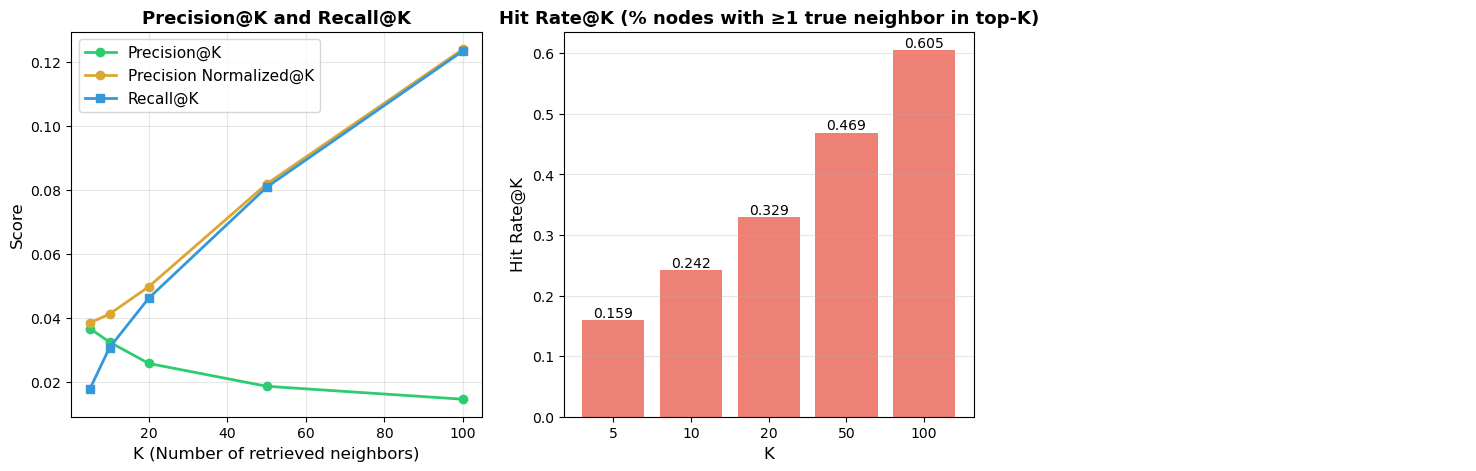

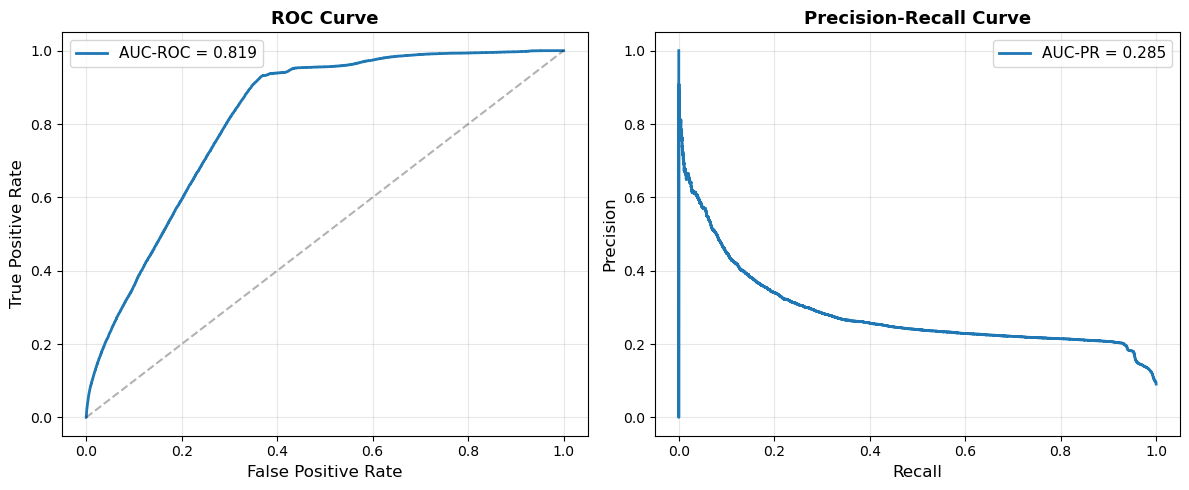

<Figure size 640x480 with 0 Axes>

In [15]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat" / "utils" / "evaluation"))

from link_prediction import (
    evaluate_network_link_prediction,
    plot_link_prediction_results
)

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Evaluate fine-tuned model using the SAME nodes as validation
print(f"Evaluating on test set: {len(test_val_nodes)} nodes")
results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,  # Same as validation nodes
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

# Visualize
plot_link_prediction_results(results['topk'], results['auc'])

In [10]:
# Load baseline SciBERT (not fine-tuned)
print("Loading baseline model...")
baseline_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased").to(device)
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Compute baseline embeddings
print("Computing baseline embeddings...")
baseline_embeddings = compute_embeddings(
    baseline_model,
    tokenizer,
    metadata_df,
    device,
    batch_size=32
)

print(f"✓ Baseline embeddings: {len(baseline_embeddings)} nodes")

Loading baseline model...
Computing baseline embeddings...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
✓ Baseline embeddings: 14442 nodes


In [10]:
# Evaluate baseline
print("Evaluating baseline...")
baseline_results = evaluate_network_link_prediction(
    edgelist_path=str(edgelist_path),
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,
    k_values=[5, 10, 20, 50, 100],
    compute_auc=True,
    num_negative_samples=10
)

Evaluating baseline...

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1439

Evaluating link prediction with top-k retrieval...
Test nodes: 1439
K values: [5, 10, 20, 50, 100]


Evaluating nodes:   0%|          | 0/1439 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Create comparison table
k_values = [5, 10, 20, 50, 100]
comparison_data = []

for k in k_values:
    baseline_prec = baseline_results['topk']['summary'][k]['precision@k']
    finetuned_prec = results['topk']['summary'][k]['precision@k']

    comparison_data.append({
        'K': k,
        'Baseline Precision': baseline_prec,
        'Fine-tuned Precision': finetuned_prec,
        'Improvement': finetuned_prec - baseline_prec,
        'Improvement %': ((finetuned_prec - baseline_prec) / baseline_prec) * 100
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("PRECISION@K COMPARISON: Baseline vs Fine-tuned (DCAT Triplet Loss)")
print("="*80)
print(comparison_df.to_string(index=False))

# AUC comparison
print("\n" + "="*80)
print("AUC METRICS")
print("="*80)
print(f"Baseline AUC-ROC:    {baseline_results['auc']['auc_roc']:.4f}")
print(f"Fine-tuned AUC-ROC:  {results['auc']['auc_roc']:.4f}")
print(f"Improvement:         {results['auc']['auc_roc'] - baseline_results['auc']['auc_roc']:.4f} " +
      f"({((results['auc']['auc_roc'] - baseline_results['auc']['auc_roc'])/baseline_results['auc']['auc_roc'])*100:.1f}%)")
print()
print(f"Baseline AUC-PR:     {baseline_results['auc']['auc_pr']:.4f}")
print(f"Fine-tuned AUC-PR:   {results['auc']['auc_pr']:.4f}")
print(f"Improvement:         {results['auc']['auc_pr'] - baseline_results['auc']['auc_pr']:.4f} " +
      f"({((results['auc']['auc_pr'] - baseline_results['auc']['auc_pr'])/baseline_results['auc']['auc_pr'])*100:.1f}%)")

# Visualize
plot_link_prediction_results(baseline_results['topk'], baseline_results['auc'])

In [ ]:
from sklearn.metrics import roc_curve

# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AUC-ROC
ax = axes[0]

fpr, tpr, _ = roc_curve(results['auc']['y_true'], results['auc']['y_scores'])
baseline_fpr, baseline_tpr, _ = roc_curve(results['auc']['y_true'], baseline_results['auc']['y_scores'])

ax.plot(baseline_fpr, baseline_tpr, linewidth=2, label=f"Baseline = {baseline_results['auc']['auc_roc']:.3f}", color='#95a5a6')
ax.plot(fpr, tpr, linewidth=2, label=f"D-CAT = {results['auc']['auc_roc']:.3f}", color='#3498db')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('AUC-ROC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)

# Hit Rate @ K
ax = axes[1]
x = np.arange(len(k_values))
width = 0.35

baseline_prec = [baseline_results['topk']['summary'][k]['hit_rate@k'] for k in k_values]
finetuned_prec = [results['topk']['summary'][k]['hit_rate@k'] for k in k_values]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='D-CAT', alpha=0.8, color='#3498db')

ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Hits@K', fontsize=12)
ax.set_title('Link Prediction: Hits@K', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(k_values)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Create text dictionary for content evaluation
text_dict = {}
for _, row in metadata_df.iterrows():
    node_id = str(row['id'])
    title = str(row['title']) if pd.notna(row['title']) else ''
    abstract = str(row['abstract']) if pd.notna(row['abstract']) else ''
    
    combined_text = f"{title} {abstract}".strip()
    if combined_text:
        text_dict[node_id] = combined_text

print(f"Created text dictionary with {len(text_dict)} entries")

# Verify overlap
overlap = set(embeddings_dict.keys()) & set(text_dict.keys())
print(f"Overlap: {len(overlap)} keys in common")

Created text dictionary with 14442 entries
Overlap: 14442 keys in common


In [12]:
# Import evaluation functions
sys.path.insert(0, str(BASE_DIR / "cat"))

from utils.evaluation.content_eval import evaluate_content_preservation

content_results = evaluate_content_preservation(
    embeddings_dict=embeddings_dict,
    baseline_embeddings_dict=baseline_embeddings,
    content_dict=text_dict,
    test_nodes=test_val_nodes,
    sample_size=2000,
    random_state=42
)


               CONTENT PRESERVATION EVALUATION

Evaluating fine-tuned embeddings...

EMBEDDING-BM25 CORRELATION EVALUATION
Evaluating 1444 nodes with both embeddings and content
Tokenizing documents...


Tokenizing:   0%|          | 0/1444 [00:00<?, ?it/s]

Building BM25 index...
Sampling 2000 pairs...
Computing similarities...


Computing pairs:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.1292 (p=6.63e-09)
Pearson correlation: 0.1557 (p=2.55e-12)
Number of pairs evaluated: 2000

Mean embedding similarity by BM25 score quantile:
  Q0-25: emb_sim=0.0909 ± 0.5407, bm25=[0.00, 127.82] (500 pairs)
  Q25-50: emb_sim=0.0598 ± 0.5341, bm25=[127.82, 158.69] (500 pairs)
  Q50-75: emb_sim=0.1476 ± 0.5821, bm25=[158.69, 195.80] (500 pairs)
  Q75-90: emb_sim=0.2786 ± 0.6171, bm25=[195.80, 235.78] (300 pairs)
  Q90-95: emb_sim=0.2486 ± 0.6015, bm25=[235.78, 263.14] (100 pairs)
  Q95-100: emb_sim=0.5052 ± 0.6051, bm25=[263.14, 514.49] (100 pairs)

Evaluating baseline embeddings...

EMBEDDING-BM25 CORRELATION EVALUATION
Evaluating 1444 nodes with both embeddings and content
Tokenizing documents...


Tokenizing:   0%|          | 0/1444 [00:00<?, ?it/s]

Building BM25 index...
Sampling 2000 pairs...
Computing similarities...


Computing pairs:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.3111 (p=3.83e-46)
Pearson correlation: 0.3297 (p=6.29e-52)
Number of pairs evaluated: 2000

Mean embedding similarity by BM25 score quantile:
  Q0-25: emb_sim=0.6459 ± 0.1028, bm25=[0.00, 127.82] (500 pairs)
  Q25-50: emb_sim=0.6869 ± 0.0866, bm25=[127.82, 158.69] (500 pairs)
  Q50-75: emb_sim=0.7024 ± 0.0856, bm25=[158.69, 195.80] (500 pairs)
  Q75-90: emb_sim=0.7199 ± 0.0862, bm25=[195.80, 235.78] (300 pairs)
  Q90-95: emb_sim=0.7251 ± 0.0724, bm25=[235.78, 263.14] (100 pairs)
  Q95-100: emb_sim=0.7421 ± 0.0930, bm25=[263.14, 514.49] (100 pairs)

SUMMARY

Fine-tuned Model BM25 Correlation:
  Spearman ρ: 0.1292
  Pearson r: 0.1557
  Nodes evaluated: 1444
  Pairs sampled: 2000

Baseline Model BM25 Correlation:
  Spearman ρ: 0.3111
  Pearson r: 0.3297
  Nodes evaluated: 1444
  Pairs sampled: 2000

Difference (Fine-tuned - Baseline):
  Δ Spearman ρ: -0.1819
  Δ Pearson r: -0.1740



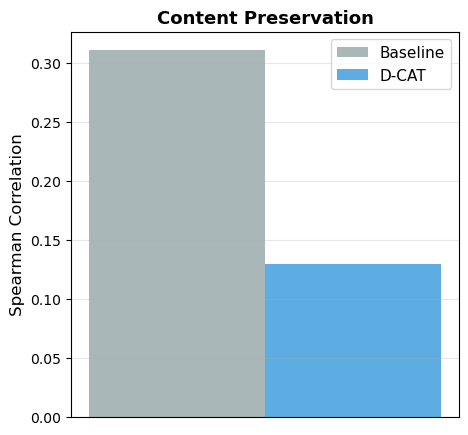

In [13]:
baseline_spearman = content_results['baseline']['spearman_correlation']
finetuned_spearman = content_results['finetuned']['spearman_correlation']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = np.arange(1)
width = 0.35

baseline_prec = [baseline_spearman]
finetuned_prec = [finetuned_spearman]

bars1 = ax.bar(x - width/2, baseline_prec, width, label='Baseline', alpha=0.8, color='#95a5a6')
bars2 = ax.bar(x + width/2, finetuned_prec, width, label='D-CAT', alpha=0.8, color='#3498db')

ax.set_ylabel('Spearman Correlation', fontsize=12)
ax.set_title('Content Preservation', fontsize=13, fontweight='bold')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Building NetworkKit graph...
Graph has 14384 nodes and 111873 edges
Test nodes with embeddings and in graph: 1439

Sampling node pairs (strategy: stratified)...
Sampling from 1439 test nodes...


Stratified sampling:   0%|          | 0/1439 [00:00<?, ?it/s]

Sampled 132074 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/1439 [00:00<?, ?it/s]

Pairs with finite graph distance: 132074

Computing embedding distances (metric: cosine)...

Final pair count: 132074

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.3753 (p=0.0000e+00)
  Pearson correlation: 0.5816 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 11807 pairs, mean emb dist = 0.0900 ± 0.2817
  Distance 2: 14567 pairs, mean emb dist = 0.1570 ± 0.3802
  Distance 3: 14619 pairs, mean emb dist = 0.3584 ± 0.5514
  Distance 4: 14619 pairs, mean emb dist = 0.8752 ± 0.6147
  Distance 5: 14619 pairs, mean emb dist = 1.2147 ± 0.4288
  Distance 6: 14619 pairs, mean emb dist = 1.2108 ± 0.2450
  Distance 7: 14619 pairs, mean emb dist = 1.0828 ± 0.1681
  Distance 8: 14537 pairs, mean emb dist = 1.0374 ± 0.1532
  Distance 9: 12988 pairs, mean emb dist = 1.0140 ± 0.1625
  Distance 10: 5080 pairs, mean emb dist = 0.9247 ± 0.1601



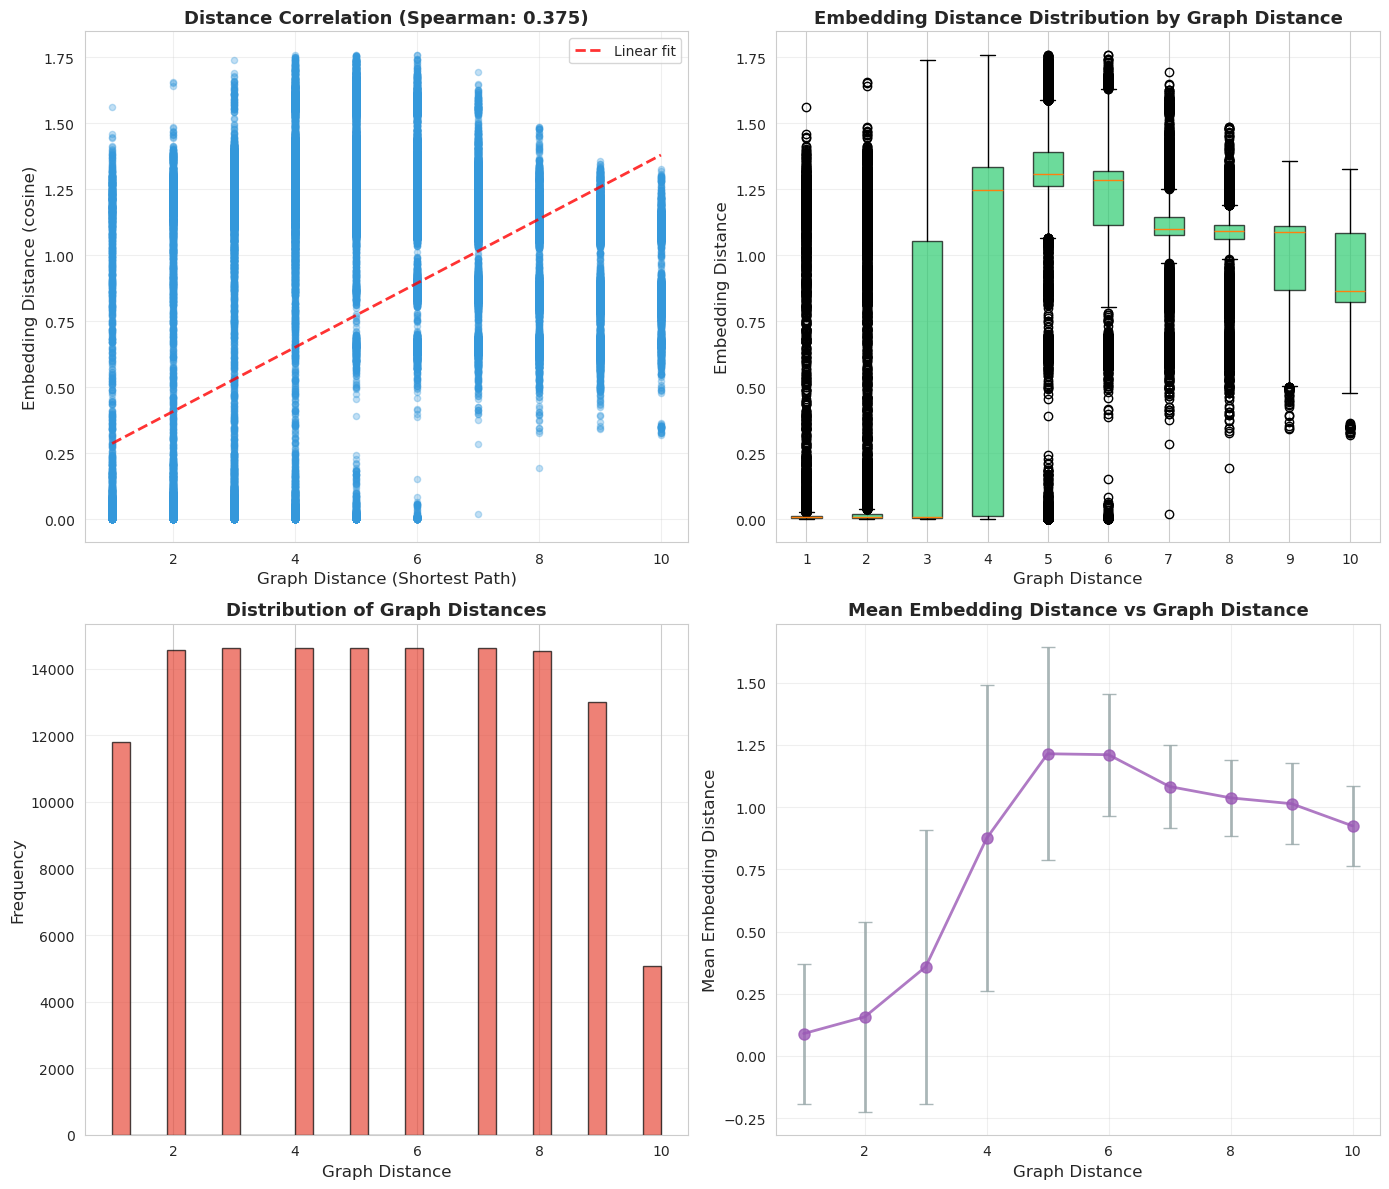

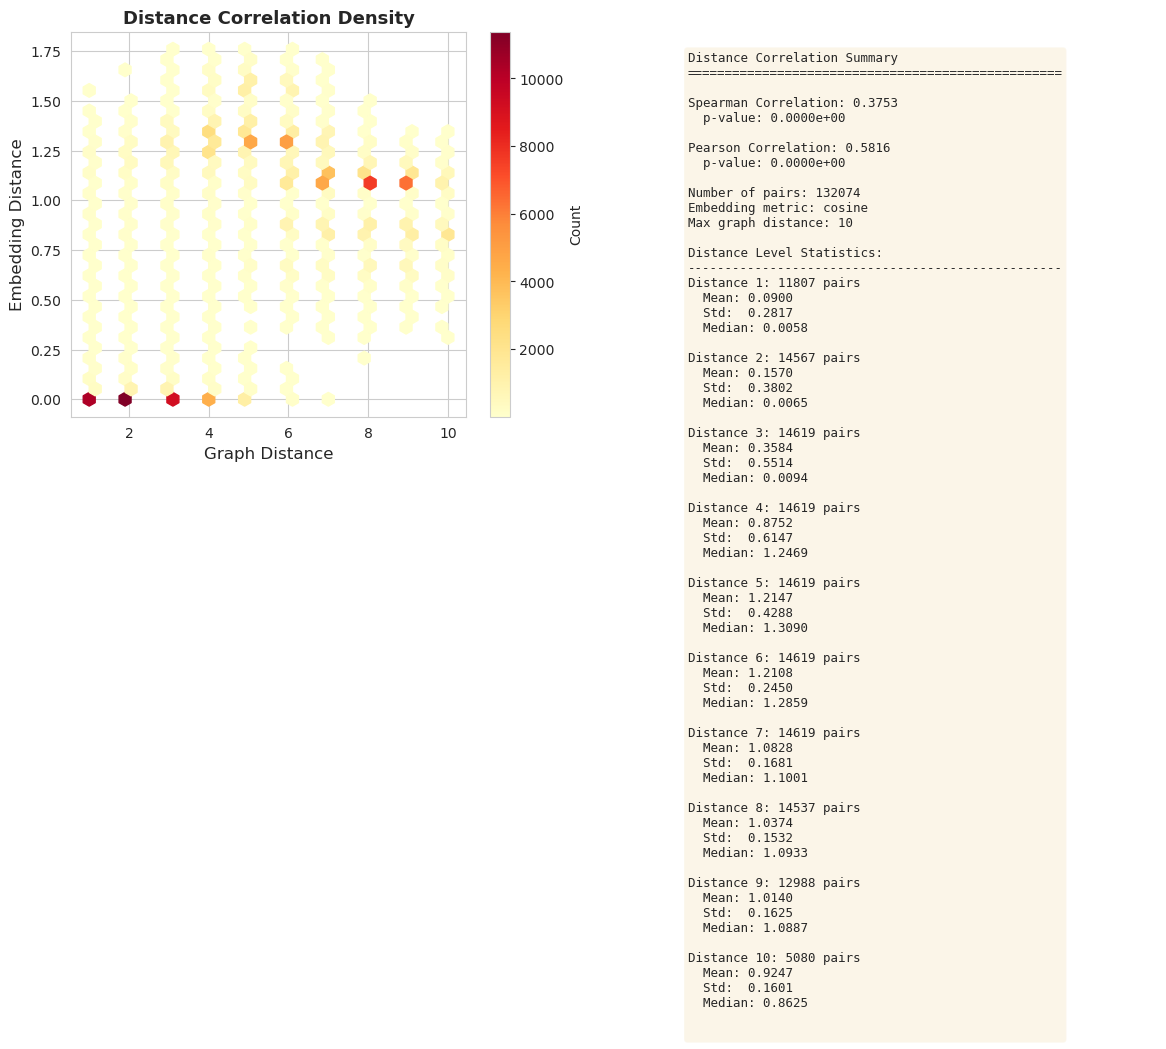

In [14]:
from utils.evaluation.graph_dist_eval import evaluate_distance_correlation, plot_distance_correlation

edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Evaluate fine-tuned model
finetuned_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,
    num_samples_per_node=100,
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'
)

plot_distance_correlation(finetuned_distance_evaluation)


GRAPH DISTANCE CORRELATION EVALUATION

Loading edgelist from: /home/vikramr2/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Building NetworkKit graph...
Graph has 14384 nodes and 111873 edges
Test nodes with embeddings and in graph: 1439

Sampling node pairs (strategy: stratified)...
Sampling from 1439 test nodes...


Stratified sampling:   0%|          | 0/1439 [00:00<?, ?it/s]

Sampled 132074 pairs

Computing shortest path distances...


Computing shortest paths:   0%|          | 0/1439 [00:00<?, ?it/s]

Pairs with finite graph distance: 132074

Computing embedding distances (metric: cosine)...

Final pair count: 132074

Computing correlations...

RESULTS SUMMARY

Correlation Metrics:
  Spearman correlation: 0.3897 (p=0.0000e+00)
  Pearson correlation: 0.3779 (p=0.0000e+00)

Distance Distribution:
  Distance 1: 11807 pairs, mean emb dist = 0.2524 ± 0.1094
  Distance 2: 14567 pairs, mean emb dist = 0.2546 ± 0.1004
  Distance 3: 14619 pairs, mean emb dist = 0.2686 ± 0.1002
  Distance 4: 14619 pairs, mean emb dist = 0.2923 ± 0.1009
  Distance 5: 14619 pairs, mean emb dist = 0.3250 ± 0.0949
  Distance 6: 14619 pairs, mean emb dist = 0.3409 ± 0.0853
  Distance 7: 14619 pairs, mean emb dist = 0.3490 ± 0.0820
  Distance 8: 14537 pairs, mean emb dist = 0.3540 ± 0.0832
  Distance 9: 12988 pairs, mean emb dist = 0.3550 ± 0.0851
  Distance 10: 5080 pairs, mean emb dist = 0.3528 ± 0.0914



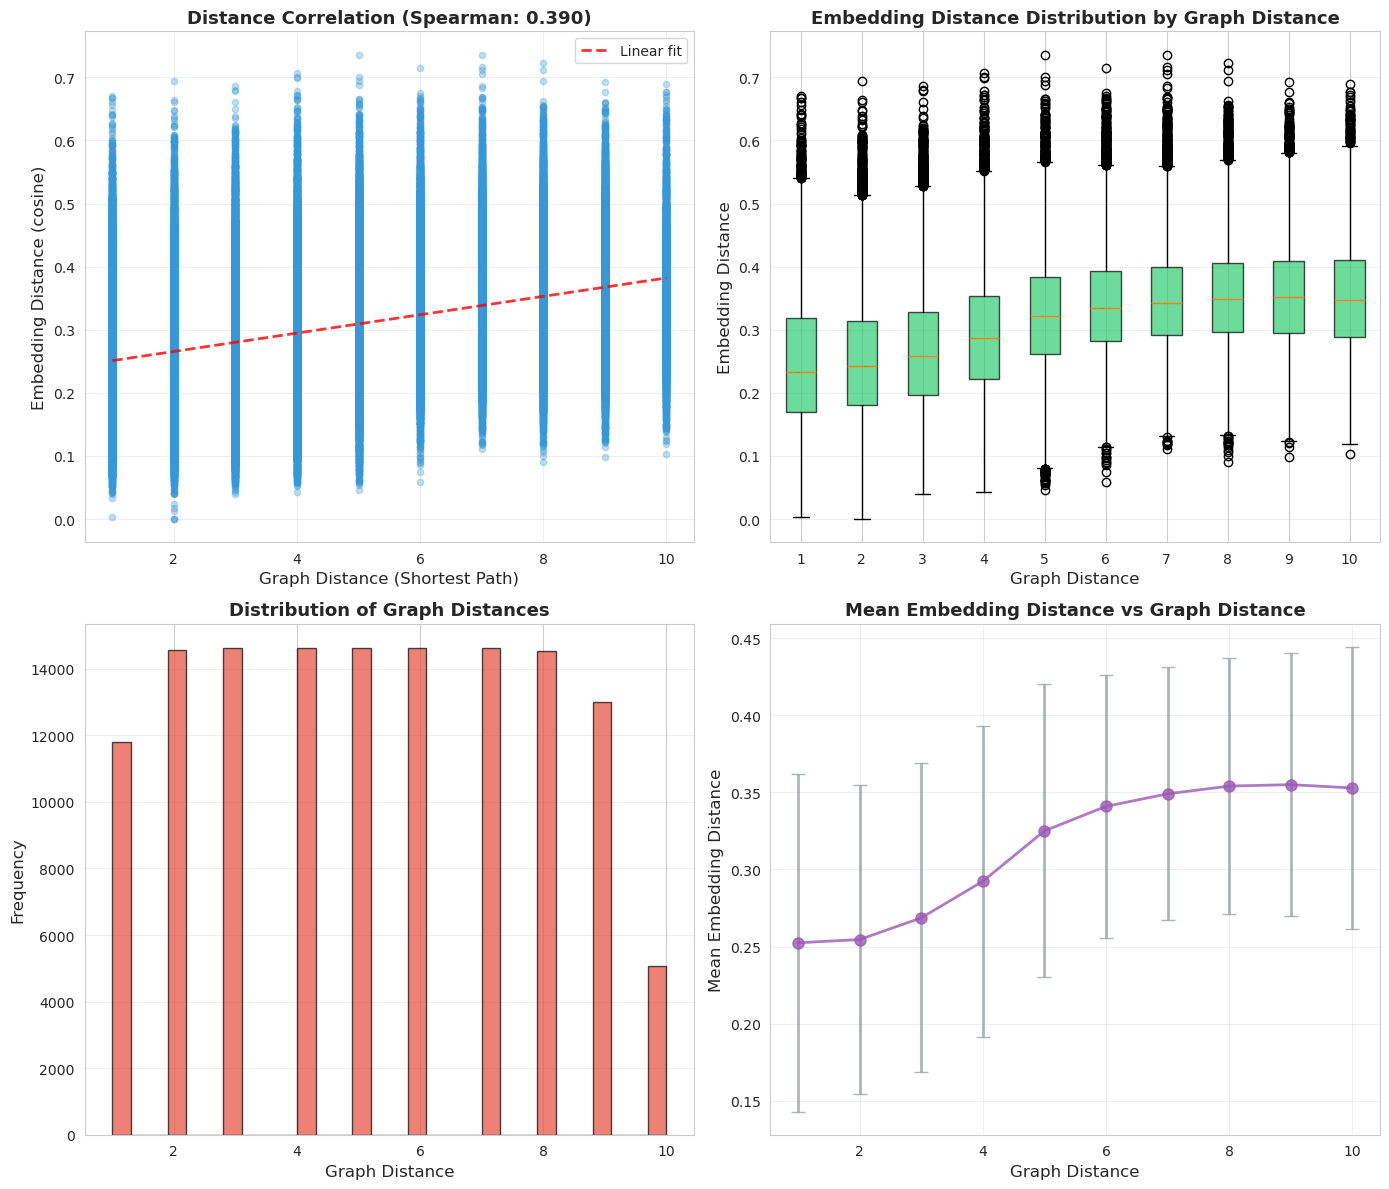

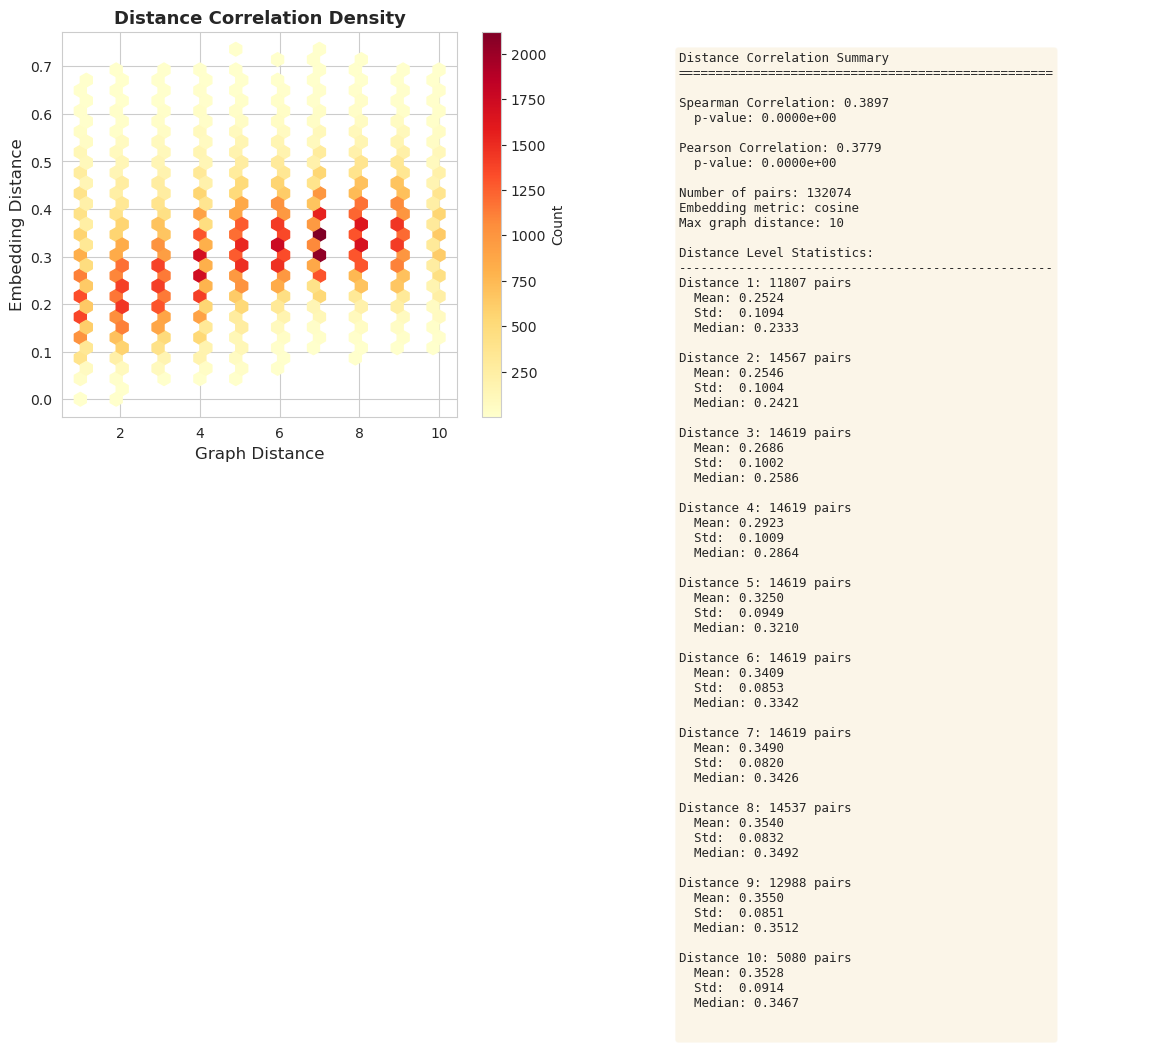

In [15]:
# Evaluate baseline model
baseline_distance_evaluation = evaluate_distance_correlation(
    edgelist_path=edgelist_path,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,
    num_samples_per_node=100,
    max_graph_distance=10,
    embedding_distance_metric='cosine',
    sampling_strategy='stratified'
)

plot_distance_correlation(baseline_distance_evaluation)

In [12]:
import json

# Open the file and load the data
with open('test_nodes.json', 'r') as file:
    test_val_nodes = json.load(file)

In [7]:
sys.path.insert(0, str(BASE_DIR / "cat" / "dcat"))
sys.path.insert(0, str(BASE_DIR / "cat"))


In [3]:
# Load clustering and metadata
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"
clustering_path = DATA_DIR / "clustering" / "disjoint" / "oc_mini_clusters_0.001.csv"

metadata_df = pd.read_csv(metadata_path)
clustering_df = pd.read_csv(clustering_path)

In [13]:
# Evaluate clustering structure preservation
from cluster_utils import DisjointClustering
from utils.evaluation.clustering_eval import evaluate_clustering_structure

# Load clustering
clustering = DisjointClustering(clustering_df)

# Evaluate baseline embeddings
baseline_cluster_results = evaluate_clustering_structure(
    clustering=clustering,
    embeddings_dict=baseline_embeddings,
    test_nodes=test_val_nodes,
    distance_sample_size=2000,
    random_state=42
)

Loaded clustering:
  Total nodes: 19705
  Total clusters: 5
  Avg cluster size: 3941.0

               CLUSTERING STRUCTURE EVALUATION

CLUSTER CLASSIFICATION EVALUATION
Cross-validation folds: 5
Evaluating 1444 test nodes
  Clusters: 5
  Samples: 1444
  Min cluster size: 120
  Max cluster size: 710
  Mean cluster size: 288.8

  Accuracy: 0.8996 ± 0.0147
  Random baseline: 0.3135
  Lift over random: 2.87x

CLUSTER DISTANCE EVALUATION
Evaluating 1444 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.3079 (p=3.63e-45)
Point-biserial correlation: 0.2973 (p=4.31e-42)
Number of pairs evaluated: 2000

Embedding distance statistics:
  Same cluster: 0.2678 ± 0.0941 (621 pairs)
  Diff cluster: 0.3288 ± 0.0891 (1379 pairs)
  Separation ratio: 0.23x

SUMMARY

Cluster Classification:
  Accuracy: 0.8996 ± 0.0147
  Random baseline: 0.3135
  Lift: 2.87x
  Clusters: 5

Cluster Distance Analysis:
  Point-biserial ρ: 0.2973
  Same cluster distance: 0.2678
  Diff cluster distance: 0.3288



In [14]:
# Evaluate fine-tuned embeddings
finetuned_cluster_results = evaluate_clustering_structure(
    clustering=clustering,
    embeddings_dict=embeddings_dict,
    test_nodes=test_val_nodes,
    distance_sample_size=2000,
    random_state=42
)


               CLUSTERING STRUCTURE EVALUATION

CLUSTER CLASSIFICATION EVALUATION
Cross-validation folds: 5
Evaluating 1444 test nodes
  Clusters: 5
  Samples: 1444
  Min cluster size: 120
  Max cluster size: 710
  Mean cluster size: 288.8

  Accuracy: 0.9868 ± 0.0051
  Random baseline: 0.3135
  Lift over random: 3.15x

CLUSTER DISTANCE EVALUATION
Evaluating 1444 test nodes
Sampling 2000 pairs...


Computing distances:   0%|          | 0/2000 [00:00<?, ?it/s]


Spearman correlation: 0.7909 (p=0.00e+00)
Point-biserial correlation: 0.9295 (p=0.00e+00)
Number of pairs evaluated: 2000

Embedding distance statistics:
  Same cluster: 0.0445 ± 0.1734 (621 pairs)
  Diff cluster: 1.2069 ± 0.2291 (1379 pairs)
  Separation ratio: 26.14x

SUMMARY

Cluster Classification:
  Accuracy: 0.9868 ± 0.0051
  Random baseline: 0.3135
  Lift: 3.15x
  Clusters: 5

Cluster Distance Analysis:
  Point-biserial ρ: 0.9295
  Same cluster distance: 0.0445
  Diff cluster distance: 1.2069



In [16]:
# Save results
results_dir = BASE_DIR / "cat" / "dcat" / "experiments" / "results"
results_dir.mkdir(parents=True, exist_ok=True)

# with open(results_dir / "content_results.json", 'w') as f:
#     json.dump(content_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

# with open(results_dir / "finetuned_cluster_results.json", 'w') as f:
#     json.dump(finetuned_cluster_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

# with open(results_dir / "baseline_cluster_results.json", 'w') as f:
#     json.dump(baseline_cluster_results, f, default=lambda o: float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

# with open(results_dir / "baseline_distance_results.json", 'w') as f:
#     json.dump(baseline_distance_evaluation, f, 
#               default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

# with open(results_dir / "finetuned_distance_results.json", 'w') as f:
#     json.dump(finetuned_distance_evaluation, f, 
#               default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

with open(results_dir / "link_prediction_results.json", 'w') as f:
    json.dump(results, f,
              default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

# with open(results_dir / "baseline_link_prediction_results.json", 'w') as f:
#     json.dump(baseline_results, f,
#               default=lambda o: o.tolist() if isinstance(o, np.ndarray) else float(o) if isinstance(o, np.floating) else int(o) if isinstance(o, np.integer) else o)

print("✓ All results saved to:", results_dir)

✓ All results saved to: /home/vikramr2/cat/dcat/experiments/results
